In [1]:
#import libs
import torch
import torch.nn as nn
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import pandas as pd
np.seed = 99 
torch.seed = 99

In [2]:
def create_datasets_and_loaders(root_path, train_transform, test_transform, train_split=0.9, batch_size=1024):
    # Dataset creation with augmentation
    dataset = datasets.ImageFolder(root=root_path, transform=train_transform)
    
    # Splitting the dataset
    train_size = int(train_split * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, validation_dataset = random_split(dataset, [train_size, val_size])

    # Adjusting validation dataset transform
    validation_dataset.dataset.transform = test_transform

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, validation_loader

In [3]:
target_size = 32
preprocess_augm = transforms.Compose([
    transforms.Resize((target_size, target_size)),
    transforms.RandomRotation(1),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.01, contrast=0.01),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1),
])

preprocess = transforms.Compose([
    transforms.Resize((target_size, target_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1)
])

# Create datasets and loaders
train_loader, validation_loader = create_datasets_and_loaders(
    'dataset/train', 
    preprocess_augm, 
    preprocess, 
    train_split=0.9, 
    batch_size=1024
)

In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Define the layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=2)
        self.conv7 = nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv8 = nn.Conv2d(128, 64, kernel_size=3, padding=1, stride=1)
        self.conv9 = nn.Conv2d(64, 32, kernel_size=3, padding=1, stride=1)
        self.conv10 = nn.Conv2d(32, 3, kernel_size=3, padding=1, stride=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Define the forward pass
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.upsample(x)
        x = self.conv8(x)
        x = self.upsample(x)
        x = self.conv9(x)
        x = self.upsample(x)
        x = self.sigmoid(self.conv10(x))
        return x
device = 'cuda'
model = Model().to(device=device)
summary(model, (3, target_size,target_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 32, 16, 16]           9,248
              ReLU-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7             [-1, 64, 8, 8]          36,928
              ReLU-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
           Conv2d-10            [-1, 128, 4, 4]         147,584
           Conv2d-11            [-1, 128, 4, 4]         147,584
         Upsample-12            [-1, 128, 8, 8]               0
           Conv2d-13             [-1, 64, 8, 8]          73,792
         Upsample-14           [-1, 64,

In [5]:
learning_rate = 0.0004
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()
#learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

Epoch 1/100, Train Loss: 0.003057, Validation Loss: 0.002364
Epoch 2/100, Train Loss: 0.002152, Validation Loss: 0.002110
Epoch 3/100, Train Loss: 0.001990, Validation Loss: 0.001939
Epoch 4/100, Train Loss: 0.001882, Validation Loss: 0.001873
Epoch 5/100, Train Loss: 0.001826, Validation Loss: 0.001826
Epoch 6/100, Train Loss: 0.001766, Validation Loss: 0.001723
Epoch 7/100, Train Loss: 0.001673, Validation Loss: 0.001734
Epoch 8/100, Train Loss: 0.001546, Validation Loss: 0.001450
Epoch 9/100, Train Loss: 0.001351, Validation Loss: 0.001299
Epoch 10/100, Train Loss: 0.001233, Validation Loss: 0.001165
Epoch 11/100, Train Loss: 0.001124, Validation Loss: 0.001045
Epoch 12/100, Train Loss: 0.000978, Validation Loss: 0.000879
Epoch 13/100, Train Loss: 0.000837, Validation Loss: 0.000778
Epoch 14/100, Train Loss: 0.000757, Validation Loss: 0.000719
Epoch 15/100, Train Loss: 0.000717, Validation Loss: 0.000707
Epoch 16/100, Train Loss: 0.000726, Validation Loss: 0.000656
Epoch 17/100, Tra

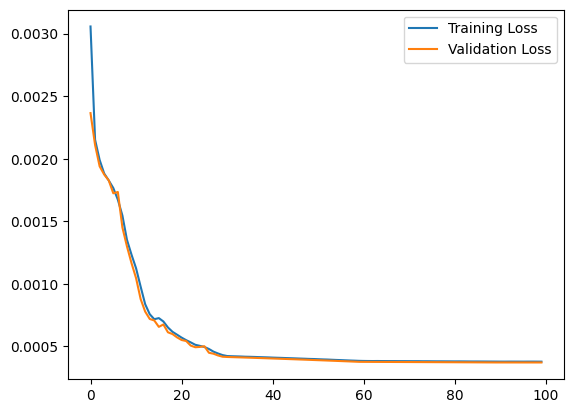

In [6]:
num_epochs = 100
train_losses = []
val_losses = []
early_stopping_patience = 10
min_val_loss = np.inf
patience_counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)
        train_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()
    
    # Validation phase
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, _ in validation_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            validation_loss += loss.item()
    
    validation_loss /= len(validation_loader)
    train_loss /= len(train_loader)
    
    train_losses.append(train_loss)
    val_losses.append(validation_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Validation Loss: {validation_loss:.6f}")

    # Early stopping check
    if validation_loss < min_val_loss:
        min_val_loss = validation_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break


torch.save(model.state_dict(), 'model.pth')
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [7]:
def compute_loss(model, dataset, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for images, _ in DataLoader(dataset, batch_size=1, shuffle=False):
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            losses.append(loss.item())
    return np.array(losses)

def loss_df(losses, dataset):
    
    records = [{'img': path[0].split('/')[-1], 'loss': loss} for (path, loss) in zip(dataset.imgs, losses)]
    return pd.DataFrame(records)

def calculate_tpr_tnr(predictions_df, threshold):
    predictions_df['predictions'] = (predictions_df['loss'] > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(predictions_df['class'], predictions_df['predictions']).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    return tpr, tnr


In [8]:
# Compute losses for the 'proliv' dataset
proliv_dataset = ImageFolder(root='./dataset/proliv', transform=preprocess)

# Compute losses for the test dataset
test_dataset = ImageFolder(root='dataset/test/imgs/', transform=preprocess)


In [9]:
losses_proliv = compute_loss(model, proliv_dataset, criterion, device)

losses_test = compute_loss(model, test_dataset, criterion, device)

merged = pd.merge(loss_df(losses_test, test_dataset), pd.read_csv('./dataset/test/test_annotation.txt', sep=' ', names=['img', 'class']), how='left', on='img')

# Calculate TPR and TNR for different trashholds
thresholds_for_classification = [np.min(losses_proliv), np.mean(losses_proliv), np.max(losses_proliv)]

for threshold in thresholds_for_classification:
    
    tpr, tnr = calculate_tpr_tnr(merged, threshold)
    print(f"TPR: {tpr}, TNR: {tnr} with threshold = {threshold}")

TPR: 0.9612403100775194, TNR: 0.7724420190995908 with threshold = 0.000813084770925343
TPR: 0.6511627906976745, TNR: 0.9448840381991814 with threshold = 0.0018744579487625364
TPR: 0.12403100775193798, TNR: 0.9972714870395635 with threshold = 0.0032072411850094795


## Первая модель не дала требуемых метрик после обученя, попробуюоключить аугментации и изменить рамзер входного изображения еще раз провести эксперимент

In [10]:
target_size = 48
preprocess_augm = transforms.Compose([
    transforms.Resize((target_size, target_size)),
    #transforms.RandomRotation(1),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.01, contrast=0.01),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1),
])

preprocess = transforms.Compose([
    transforms.Resize((target_size, target_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1)
])

# Create datasets and loaders
train_loader, validation_loader = create_datasets_and_loaders(
    'dataset/train', 
    preprocess_augm, 
    preprocess, 
    train_split=0.9, 
    batch_size=1024
)

Epoch 1/100, Train Loss: 0.004981, Validation Loss: 0.005033
Epoch 2/100, Train Loss: 0.004980, Validation Loss: 0.005033
Epoch 3/100, Train Loss: 0.004981, Validation Loss: 0.005033
Epoch 4/100, Train Loss: 0.004980, Validation Loss: 0.005033
Epoch 5/100, Train Loss: 0.004978, Validation Loss: 0.005033
Epoch 6/100, Train Loss: 0.004980, Validation Loss: 0.005033
Epoch 7/100, Train Loss: 0.004979, Validation Loss: 0.005033
Epoch 8/100, Train Loss: 0.004977, Validation Loss: 0.005033
Epoch 9/100, Train Loss: 0.004981, Validation Loss: 0.005033
Epoch 10/100, Train Loss: 0.004979, Validation Loss: 0.005033
Early stopping triggered


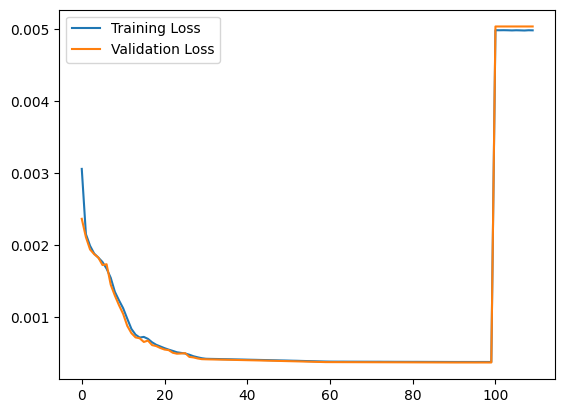

In [11]:
model = Model().to(device=device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)
        train_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()
    
    # Validation phase
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, _ in validation_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            validation_loss += loss.item()
    
    validation_loss /= len(validation_loader)
    train_loss /= len(train_loader)
    
    train_losses.append(train_loss)
    val_losses.append(validation_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Validation Loss: {validation_loss:.6f}")

    # Early stopping check
    if validation_loss < min_val_loss:
        min_val_loss = validation_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break


torch.save(model.state_dict(), 'model.pth')
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [12]:
losses_proliv = compute_loss(model, proliv_dataset, criterion, device)

losses_test = compute_loss(model, test_dataset, criterion, device)

merged = pd.merge(loss_df(losses_test, test_dataset), pd.read_csv('./dataset/test/test_annotation.txt', sep=' ', names=['img', 'class']), how='left', on='img')

# Calculate TPR and TNR for different trashholds
thresholds_for_classification = [np.min(losses_proliv), np.mean(losses_proliv), np.max(losses_proliv)]

for threshold in thresholds_for_classification:
    
    tpr, tnr = calculate_tpr_tnr(merged, threshold)
    print(f"TPR: {tpr}, TNR: {tnr} with threshold = {threshold}")

TPR: 1.0, TNR: 0.6414733969986357 with threshold = 0.005853950511664152
TPR: 0.6356589147286822, TNR: 0.835743519781719 with threshold = 0.00829556348503797
TPR: 0.13953488372093023, TNR: 0.9678035470668486 with threshold = 0.011501699686050415


## Отключение ауемнтаций не дало резльтат, теперь попробую изменить архитектуру энодера, вернув аугнтации, но сохранив разрешение 48ч48 

In [13]:
target_size = 48
preprocess_augm = transforms.Compose([
    transforms.Resize((target_size, target_size)),
    transforms.RandomRotation(1),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.01, contrast=0.01),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1),
])

preprocess = transforms.Compose([
    transforms.Resize((target_size, target_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1)
])

# Create datasets and loaders
train_loader, validation_loader = create_datasets_and_loaders(
    'dataset/train', 
    preprocess_augm, 
    preprocess, 
    train_split=0.9, 
    batch_size=1024
)

In [18]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
       # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # Bottleneck layer
            nn.Conv2d(64, 16, kernel_size=1, padding=0),  # Reduced channels
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # Upsample to 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # Upsample to 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # Upsample to 64x64
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
device = 'cuda'
model = Model().to(device=device)
summary(model, (3, target_size,target_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             448
              ReLU-2           [-1, 16, 48, 48]               0
         MaxPool2d-3           [-1, 16, 24, 24]               0
            Conv2d-4           [-1, 32, 24, 24]           4,640
              ReLU-5           [-1, 32, 24, 24]               0
         MaxPool2d-6           [-1, 32, 12, 12]               0
            Conv2d-7           [-1, 64, 12, 12]          18,496
              ReLU-8           [-1, 64, 12, 12]               0
         MaxPool2d-9             [-1, 64, 6, 6]               0
           Conv2d-10             [-1, 16, 6, 6]           1,040
             ReLU-11             [-1, 16, 6, 6]               0
  ConvTranspose2d-12           [-1, 64, 12, 12]           9,280
             ReLU-13           [-1, 64, 12, 12]               0
  ConvTranspose2d-14           [-1, 32,

Epoch 1/100, Train Loss: 0.005631, Validation Loss: 0.005288
Epoch 2/100, Train Loss: 0.004975, Validation Loss: 0.004310
Epoch 3/100, Train Loss: 0.003761, Validation Loss: 0.003325
Epoch 4/100, Train Loss: 0.003051, Validation Loss: 0.002751
Epoch 5/100, Train Loss: 0.002679, Validation Loss: 0.002534
Epoch 6/100, Train Loss: 0.002519, Validation Loss: 0.002429
Epoch 7/100, Train Loss: 0.002446, Validation Loss: 0.002383
Epoch 8/100, Train Loss: 0.002403, Validation Loss: 0.002346
Epoch 9/100, Train Loss: 0.002370, Validation Loss: 0.002316
Epoch 10/100, Train Loss: 0.002343, Validation Loss: 0.002290
Epoch 11/100, Train Loss: 0.002315, Validation Loss: 0.002261
Epoch 12/100, Train Loss: 0.002283, Validation Loss: 0.002228
Epoch 13/100, Train Loss: 0.002248, Validation Loss: 0.002189
Epoch 14/100, Train Loss: 0.002202, Validation Loss: 0.002138
Epoch 15/100, Train Loss: 0.002142, Validation Loss: 0.002069
Epoch 16/100, Train Loss: 0.002051, Validation Loss: 0.001959
Epoch 17/100, Tra

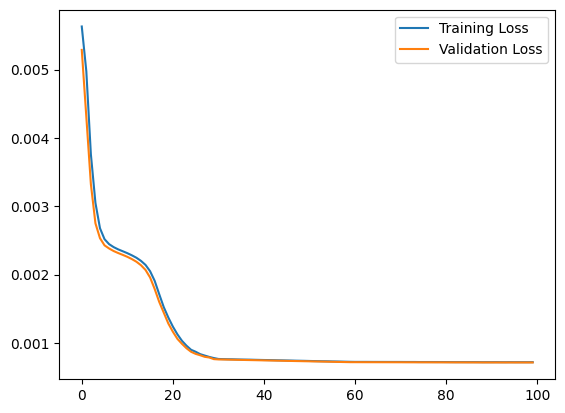

In [19]:
learning_rate = 0.0004
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()
#learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
num_epochs = 100
train_losses = []
val_losses = []
early_stopping_patience = 10
min_val_loss = np.inf
patience_counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)
        train_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()

    # Validation phase
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, _ in validation_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            validation_loss += loss.item()

    validation_loss /= len(validation_loader)
    train_loss /= len(train_loader)

    train_losses.append(train_loss)
    val_losses.append(validation_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Validation Loss: {validation_loss:.6f}")

    # Early stopping check
    if validation_loss < min_val_loss:
        min_val_loss = validation_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

torch.save(model.state_dict(), 'model.pth')
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [20]:
losses_proliv = compute_loss(model, proliv_dataset, criterion, device)

losses_test = compute_loss(model, test_dataset, criterion, device)

merged = pd.merge(loss_df(losses_test, test_dataset), pd.read_csv('./dataset/test/test_annotation.txt', sep=' ', names=['img', 'class']), how='left', on='img')

# Calculate TPR and TNR for different trashholds
thresholds_for_classification = [np.min(losses_proliv), np.mean(losses_proliv), np.max(losses_proliv)]

for threshold in thresholds_for_classification:
    
    tpr, tnr = calculate_tpr_tnr(merged, threshold)
    print(f"TPR: {tpr}, TNR: {tnr} with threshold = {threshold}")

TPR: 0.7906976744186046, TNR: 0.8695770804911324 with threshold = 0.0018951495876535773
TPR: 0.6666666666666666, TNR: 0.984993178717599 with threshold = 0.003297863980942684
TPR: 0.05426356589147287, TNR: 0.9926330150068213 with threshold = 0.005804999731481075


## С измененной моделью результаты стали еще хуже, поэтому попробую еще одну моедль

In [21]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
device = 'cuda'
model = Model().to(device=device)
summary(model, (3, target_size,target_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             896
              ReLU-2           [-1, 32, 48, 48]               0
            Conv2d-3           [-1, 32, 24, 24]           9,248
              ReLU-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          18,496
              ReLU-6           [-1, 64, 24, 24]               0
            Conv2d-7           [-1, 64, 12, 12]          36,928
              ReLU-8           [-1, 64, 12, 12]               0
            Conv2d-9          [-1, 128, 12, 12]          73,856
           Conv2d-10            [-1, 128, 6, 6]         147,584
           Conv2d-11            [-1, 128, 6, 6]         147,584
         Upsample-12          [-1, 128, 12, 12]               0
           Conv2d-13           [-1, 64, 12, 12]          73,792
         Upsample-14           [-1, 64,

Epoch 1/100, Train Loss: 0.003171, Validation Loss: 0.002564
Epoch 2/100, Train Loss: 0.002318, Validation Loss: 0.002130
Epoch 3/100, Train Loss: 0.002108, Validation Loss: 0.001979
Epoch 4/100, Train Loss: 0.001913, Validation Loss: 0.001691
Epoch 5/100, Train Loss: 0.001666, Validation Loss: 0.001474
Epoch 6/100, Train Loss: 0.001411, Validation Loss: 0.001258
Epoch 7/100, Train Loss: 0.001226, Validation Loss: 0.001148
Epoch 8/100, Train Loss: 0.001099, Validation Loss: 0.001009
Epoch 9/100, Train Loss: 0.000975, Validation Loss: 0.000892
Epoch 10/100, Train Loss: 0.000853, Validation Loss: 0.000773
Epoch 11/100, Train Loss: 0.000741, Validation Loss: 0.000682
Epoch 12/100, Train Loss: 0.000651, Validation Loss: 0.000626
Epoch 13/100, Train Loss: 0.000615, Validation Loss: 0.000568
Epoch 14/100, Train Loss: 0.000571, Validation Loss: 0.000571
Epoch 15/100, Train Loss: 0.000542, Validation Loss: 0.000520
Epoch 16/100, Train Loss: 0.000519, Validation Loss: 0.000544
Epoch 17/100, Tra

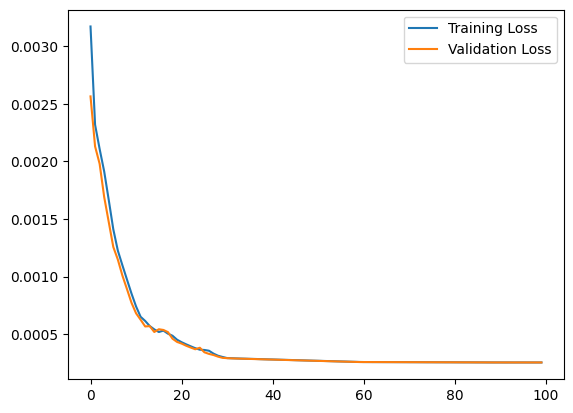

In [22]:
learning_rate = 0.0004
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()
#learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
num_epochs = 100
train_losses = []
val_losses = []
early_stopping_patience = 10
min_val_loss = np.inf
patience_counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)
        train_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()

    # Validation phase
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, _ in validation_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            validation_loss += loss.item()

    validation_loss /= len(validation_loader)
    train_loss /= len(train_loader)

    train_losses.append(train_loss)
    val_losses.append(validation_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Validation Loss: {validation_loss:.6f}")

    # Early stopping check
    if validation_loss < min_val_loss:
        min_val_loss = validation_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

torch.save(model.state_dict(), 'model.pth')
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [23]:
losses_proliv = compute_loss(model, proliv_dataset, criterion, device)

losses_test = compute_loss(model, test_dataset, criterion, device)

merged = pd.merge(loss_df(losses_test, test_dataset), pd.read_csv('./dataset/test/test_annotation.txt', sep=' ', names=['img', 'class']), how='left', on='img')

# Calculate TPR and TNR for different trashholds
thresholds_for_classification = [np.min(losses_proliv), np.mean(losses_proliv), np.max(losses_proliv)]

for threshold in thresholds_for_classification:
    
    tpr, tnr = calculate_tpr_tnr(merged, threshold)
    print(f"TPR: {tpr}, TNR: {tnr} with threshold = {threshold}")

TPR: 0.813953488372093, TNR: 0.7356070941336972 with threshold = 0.0007999888039194047
TPR: 0.6589147286821705, TNR: 0.9508867667121419 with threshold = 0.001862607089358128
TPR: 0.12403100775193798, TNR: 0.9967257844474762 with threshold = 0.003308207495138049
